In [58]:
#!pip install google-cloud

In [59]:
#!pip install db-dtypes

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
from google.cloud import bigquery
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression

In [61]:
client = bigquery.Client()

In [62]:
sql = """
SELECT *
FROM `kbs_stockdata.apple_stockdata`

"""
dataset = client.query(sql).to_dataframe()


In [63]:
dataset.head(15)

,Date,Open,High,Low,Close,AdjClose,Volume
0,2005-12-21,2.592857,2.628929,2.590714,2.625000,2.247721,475736800
1,2007-04-03,3.362143,3.401071,3.348571,3.375000,2.889926,583934400
2,2007-07-19,5.010714,5.028929,4.987500,5.000000,4.281374,732891600
3,2014-10-31,27.002501,27.010000,26.802500,27.000000,24.308453,178557200
4,2016-08-10,27.177500,27.225000,26.940001,27.000000,25.252613,96034000
5,2017-01-17,29.584999,30.059999,29.555000,30.000000,28.202526,137759200
6,2017-01-20,30.112499,30.112499,29.932501,30.000000,28.202526,130391600
7,2020-09-11,114.570000,115.230003,110.000000,112.000000,110.980667,180860300
8,1982-05-19,0.063058,0.063058,0.062500,0.062500,0.048853,75286400
9,1982-05-27,0.063058,0.063058,0.062500,0.062500,0.048853,31248000


In [64]:
dataset.describe()

,Open,High,Low,Close,AdjClose,Volume
count,10409.000000,10409.000000,10409.000000,10409.000000,10409.000000,1.040900e+04
mean,13.959910,14.111936,13.809163,13.966757,13.350337,3.321778e+08
std,30.169244,30.514878,29.835055,30.191696,29.911132,3.393344e+08
min,0.049665,0.049665,0.049107,0.049107,0.038384,0.000000e+00
25%,0.281964,0.287946,0.274554,0.281250,0.234799,1.247604e+08
50%,0.468750,0.477679,0.459821,0.468750,0.386853,2.199680e+08
75%,14.217857,14.364286,14.043571,14.206071,12.188149,4.126108e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,7.421641e+09


In [65]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      10409 non-null  dbdate 
 1   Open      10409 non-null  float64
 2   High      10409 non-null  float64
 3   Low       10409 non-null  float64
 4   Close     10409 non-null  float64
 5   AdjClose  10409 non-null  float64
 6   Volume    10409 non-null  Int64  
dtypes: Int64(1), dbdate(1), float64(5)
memory usage: 579.5 KB


In [66]:
dataset.isnull().sum()

Date        0
Open        0
High        0
Low         0
Close       0
AdjClose    0
Volume      0
dtype: int64

In [67]:
# high value minus low value for daily stock value
dataset['Diff'] = dataset['High'] - dataset['Low']
dataset['Diff']

0        0.038215
1        0.052500
2        0.041429
3        0.207500
4        0.284999
           ...   
10404    0.023437
10405    0.007813
10406    0.011300
10407    0.004465
10408    0.007812
Name: Diff, Length: 10409, dtype: float64

<AxesSubplot:>

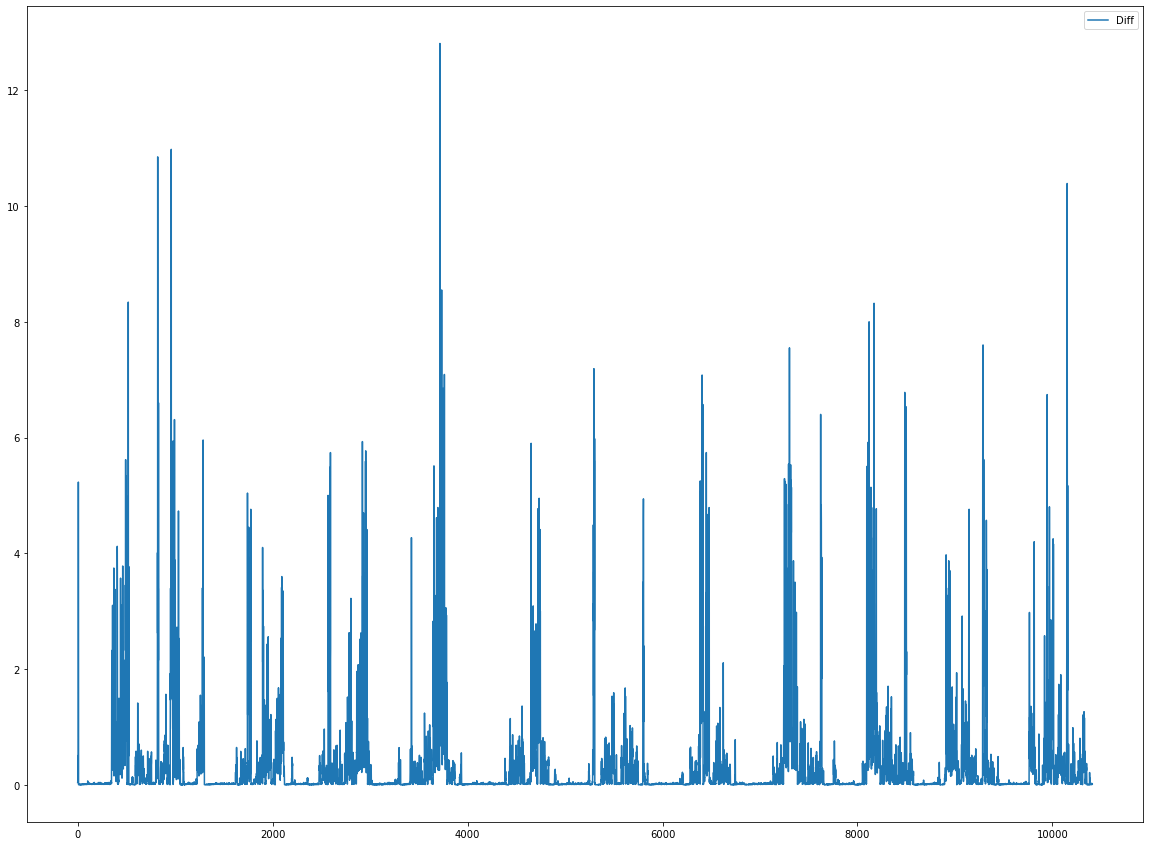

In [68]:
dataset['Diff'].plot(legend=True, figsize=(20,15))

In [69]:
# We'll use pct_change to find the percent change for each day
dataset['Daily_Return'] = dataset['Close'].pct_change()

dataset.at[0,'Daily_Return']=0.0
dataset['Daily_Return']

0        0.000000
1        0.285714
2        0.481481
3        4.400000
4        0.000000
           ...   
10404    0.079320
10405    0.073491
10406    0.068460
10407    0.000000
10408    0.000000
Name: Daily_Return, Length: 10409, dtype: float64

<AxesSubplot:>

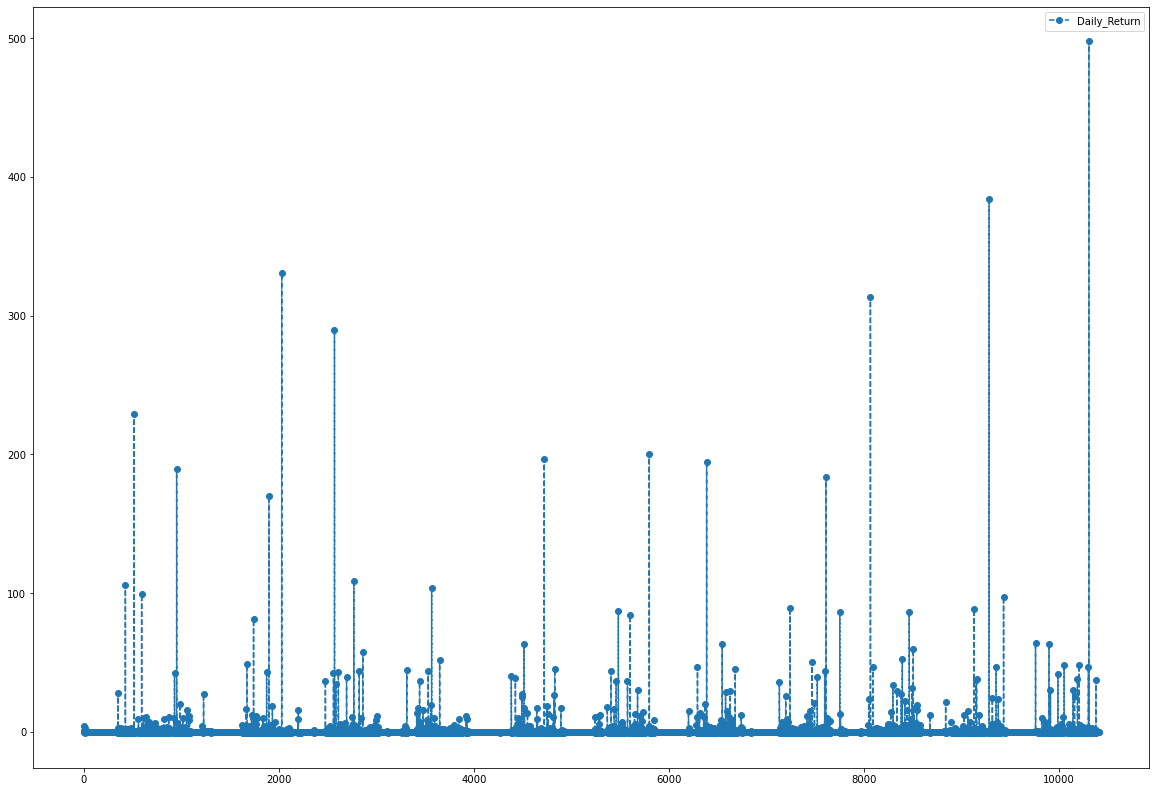

In [70]:
dataset['Daily_Return'].plot(figsize=(20,14), legend=True, linestyle='--', marker='o')

In [71]:
#Data Preparation 
x = dataset[['Open','Close','Low','AdjClose','Daily_Return']]
y = dataset['High']
x.head()

,Open,Close,Low,AdjClose,Daily_Return
0,2.592857,2.625,2.590714,2.247721,0.000000
1,3.362143,3.375,3.348571,2.889926,0.285714
2,5.010714,5.000,4.987500,4.281374,0.481481
3,27.002501,27.000,26.802500,24.308453,4.400000
4,27.177500,27.000,26.940001,25.252613,0.000000


In [72]:
# Split into test and training sets
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size=test_size, random_state=seed)

In [73]:
x_train

,Open,Close,Low,AdjClose,Daily_Return
145,0.293527,0.296875,0.293527,0.249717,0.000000
4989,0.204241,0.202009,0.199777,0.172975,0.000000
2537,2.763929,2.650000,2.616071,2.269127,1.277603
7048,0.381696,0.381696,0.379464,0.301031,0.000000
6917,0.217634,0.222098,0.215402,0.190177,0.000000
...,...,...,...,...,...
919,0.254286,0.260357,0.252857,0.222937,0.000000
4307,0.305804,0.302455,0.301339,0.240278,0.000000
5699,0.360893,0.355179,0.355179,0.304131,0.096472
537,0.149554,0.146763,0.146763,0.114717,0.000000


In [74]:
x_test

,Open,Close,Low,AdjClose,Daily_Return
3508,0.310357,0.314286,0.304643,0.269115,0.248227
5421,24.212500,24.417500,24.160000,21.874586,-0.036975
4277,0.142857,0.143415,0.142857,0.112100,0.000000
8677,0.243304,0.245536,0.243304,0.210246,0.000000
3885,0.071987,0.070313,0.070313,0.054960,0.000000
...,...,...,...,...,...
3675,39.062500,38.669998,38.527500,37.492191,0.115374
3750,161.119995,161.410004,159.059998,161.204620,0.247276
7169,1.308214,1.318571,1.306071,1.129059,-0.255796
10135,0.563036,0.548214,0.544286,0.469422,0.273859


In [75]:
y_train

145     0.297991
4989    0.204241
2537    2.767857
7048    0.386161
6917    0.222098
          ...   
919     0.262321
4307    0.310268
5699    0.365179
537     0.150112
9412    0.087054
Name: High, Length: 6974, dtype: float64

In [76]:
y_test

3508       0.321429
5421      24.459999
4277       0.149554
8677       0.252232
3885       0.071987
            ...    
3675      39.532501
3750     161.800003
7169       1.330357
10135      0.566964
3626      14.413929
Name: High, Length: 3435, dtype: float64

In [77]:
# Create Regression Model
# Use Linear Regression Model to train our data
model = LinearRegression()

In [78]:
# Train the model
model.fit(x_train, y_train)

LinearRegression()

In [79]:
# Use model to make predictions
y_pred = model.predict(x_test)

In [80]:
y_pred

array([ 0.32273482, 24.48850614,  0.14981593, ...,  1.32682937,
        0.56927287, 14.42689041])

In [81]:
model.score(x_test, y_test)

0.9999456662533939

In [82]:
#The Mean Squared Error (MSE) or Mean Squared Deviation (MSD) of an estimator measures the average of error squares i.e. 
#the average squared difference between the estimated values and true value.
rms = sqrt(mean_squared_error(y_test, y_pred))

In [83]:
rms

0.22616994013340688

In [84]:
# Result
# create new data frame
df = x_test.copy()

In [85]:
# create new two colum for actual data and predicted data
df['Actual_High'] = y_test
df['Predicted_High'] = y_pred
df

,Open,Close,Low,AdjClose,Daily_Return,Actual_High,Predicted_High
3508,0.310357,0.314286,0.304643,0.269115,0.248227,0.321429,0.322735
5421,24.212500,24.417500,24.160000,21.874586,-0.036975,24.459999,24.488506
4277,0.142857,0.143415,0.142857,0.112100,0.000000,0.149554,0.149816
8677,0.243304,0.245536,0.243304,0.210246,0.000000,0.252232,0.251960
3885,0.071987,0.070313,0.070313,0.054960,0.000000,0.071987,0.077931
...,...,...,...,...,...,...,...
3675,39.062500,38.669998,38.527500,37.492191,0.115374,39.532501,39.263641
3750,161.119995,161.410004,159.059998,161.204620,0.247276,161.800003,163.175078
7169,1.308214,1.318571,1.306071,1.129059,-0.255796,1.330357,1.326829
10135,0.563036,0.548214,0.544286,0.469422,0.273859,0.566964,0.569273
